# Feature Validation Analysis - Scalp EEG

Here, we run through a validation analysis of scalp EEG data for the purposes of predicting epilepsy.

In [1]:
# comment if you don't have nb_black installed
%load_ext lab_black

In [2]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings

warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
)

from sklearn.utils import resample

import mne

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

from eztrack.io import read_derivative_npy

# if you installed sporf via README
from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
import sklearn

# this should be at least 1.0
print(sklearn.__version__)

1.1.dev0


In [4]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

# Define possible helper functions

In [5]:
def plot_subject_feature_map(dataset, desired_subject, feature_name):
    for idx, subject in enumerate(dataset["subject"]):
        if subject != desired_subject:
            continue

        # get the metadata
        ch_names = dataset["ch_names"][idx]

        # get the data
        feature_map = dataset[feature_name][idx]

        x = np.arange(feature_map.shape[1])

        sns.set_context("paper", font_scale=1.75)
        fig, ax = plt.subplots()

        y_mean = feature_map.mean(axis=0)
        y_sem = scipy.stats.sem(feature_map, axis=0)
        ax.plot(x, y_mean, color="red")
        ax.fill_between(x, y_mean - y_sem, y_mean + y_sem, color="red", alpha=0.5)

        ax.set(
            title=f"Subject {subject} - {feature_name}",
            xlabel="Time (A.U.)",
            ylabel=f"{feature_name} Value",
        )
        ax.legend()
        break

In [6]:
def _load_subject_derivs(deriv_path, read_func, subjects=None, search_str="*.npy"):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            deriv = read_func(fpath, source_check=False)

            # extract data
            ch_names = deriv.ch_names
            deriv_data = deriv.get_data()

            dataset["subject"].append(subject)
            dataset["data"].append(deriv_data)
            dataset["ch_names"].append(ch_names)

    return dataset

In [14]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")

    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [34]:
def _features_from_spatiotemporal_heatmap(deriv_data):
    features = np.hstack(
        (
            deriv_data.mean(axis=1),
            deriv_data.std(axis=1),
        ),
        #         axis=0,
    )
    return features

In [8]:
def get_Xy_matrix(dataset, feature_set):
    X = []
    y = []
    subjects = []

    for idx, subject in enumerate(dataset["subject"]):
        X_buff = []
        for feature_name in feature_set:
            feature = dataset[feature_name][idx]
            if isinstance(feature, float):
                feat = [feature]
            elif isinstance(feature, np.ndarray):
                feat = list(feature)
            else:
                feat = feature
            feat = [feature] if isinstance(feature, float) else feature
            X_buff.extend(feat)
        X_buff = np.array(X_buff)

        X.append(X_buff)
        y.append(dataset["group"][idx] > 0)
        subjects.append(subject)
    return X, y, subjects

# Define data directories

In [9]:
jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

# not ready yet
upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [10]:
root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
root = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

reference = "monopolar"
radius = "1.25"

# define derivative chains
ss_deriv_chain = Path("sourcesink") / reference
frag_deriv_chain = Path("fragility") / f"radius{radius}" / reference

# define final path
ss_deriv_dir = deriv_root / ss_deriv_chain
frag_deriv_dir = deriv_root / frag_deriv_chain

In [11]:
print(frag_deriv_dir)

/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/derivatives/fragility/radius1.25/monopolar


In [13]:
dataset = _load_subject_derivs(
    frag_deriv_dir,
    read_func=read_derivative_npy,
    subjects=None,
    search_str="*desc-perturbmatrix*.npy",
)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']


## Optionally Load in Specific Excel Sheet

In [6]:
meta_fpath = source_root / "JHU_scalp_clinical_datasheet_raw_local.xlsx"

In [8]:
meta_df = pd.read_excel(meta_fpath)
display(meta_df.head(2))

,patient_id,hospital_id,number_datasets,CLINICAL_CENTER,modality,montage,sfreq,GROUP,ETHNICITY,"Race (0=caucasian, 1=african american, 2=hispanic, 3=asian)",...,HAND,GENDER,bad_contacts,EPILEPSY_TYPE,imaging_outcome_notes,Date of Recording,Notes,include,Reason,best_window
0,101,1,1,jhh,scalp,standard 10-20,200,1,NaN,NaN,...,NaN,NaN,"Fz, Cz, E, X1-7, SpO2, EtCO2, DC03, DC04, DC05...",focal,NaN,NaN,"Lots of eye artifact. Pz looks more normal, bu...",Y,"Good after 100 s, remove Pz",100-400
1,201,2,1,jhh,scalp,standard 10-20,200,2,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",NaN,NaN,NaN,SHW',Y,Riddled with artifact,600-900


## Plot a single subject to test

In [13]:
desired_subject = "jhh01"
feature_name = "ssentropy"
plot_subject_feature_map(dataset, desired_subject, feature_name)

# Define Cross Validation Experiment

In [13]:
n_splits = 10
train_size = 0.7
random_state = 12345

In [17]:
cv = StratifiedGroupKFold(
    n_splits=n_splits, random_state=random_state, shuffle=True,
)

## Form Features from SpatioTemporal Heatmaps

In [39]:
X = []
y = []

for idx in range(len(dataset["subject"])):
    subject = dataset["subject"][idx]
    if subject in ["jhh005"]:
        continue

    ch_names = dataset["ch_names"][idx]
    deriv_data = dataset["data"][idx]

    # extract features
    X_ = _features_from_spatiotemporal_heatmap(deriv_data)

    # extract outcome
    if "jhh" in subject:
        root = jhroot
    elif "jeff" in subject:
        root = jeffroot
    elif "upmc" in subject:
        root = upmcroot
    subj_df = _get_exp_condition(subject, root)
    outcome = subj_df["exp_condition"].values[0]

    X.append(X_)
    y.append(outcome)
    subjects.append(subject)
    
X = np.array(X)
y = np.array(y)
subjects = np.array(subjects)

print(X.shape, y.shape)

(93, 32) (93,)


In [41]:
y = enc.fit_transform(y[:, np.newaxis]).squeeze()

print(X.shape)
print(y.shape)
print(y)

(93, 32)
(93,)
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Define Classification Models

In [89]:
n_features = X.shape[1]
rf_model_params = {
    "n_estimators": 1000,
    "max_features": n_features,
    "n_jobs": -1,
    "random_state": random_state,
}
lr_model_params = {
    "n_jobs": -1,
    "random_state": random_state
}

In [90]:
clf = RandomForestClassifier(**rf_model_params)

# only used if you installed cysporf
clf = ObliqueForestClassifier(**rf_model_params)
#clf = LogisticRegression(**lr_model_params)

# Run sklearn.cross_validate

In [91]:
scoring_funcs = {
    "roc_auc": roc_auc_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
    "average_precision": average_precision_score,
    "precision": "",
    "neg_brier_score": brier_score_loss,
    "recall": "",
    "f1": "",
}

# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    groups=subject_groups,
    cv=cv,
    scoring=list(scoring_funcs.keys()),
    return_estimator=True,
    return_train_score=True,
    n_jobs=1,
)

# get the estimators
estimators = scores.pop("estimator")

In [12]:
print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_fraction_pos",
    "train_mean_pred_value",
    "train_y_pred_proba",
    "train_fpr",
    "train_tpr",
    "train_fnr",
    "train_tnr",
    "train_thresholds",
    "train_subjects",
    "test_subjects",
    "test_y_pred_proba",
    "test_importances",
    "test_specificity",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]

    # append subjects
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])

    # evaluate on the test set
    y_train = y[train_inds]
    X_train = X[train_inds, :]
    y_pred_prob = estimator.predict_proba(X_train)[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_train, y_pred_prob, n_bins=10, strategy="quantile"
    )

    # append training data
    scores["train_y_pred_proba"].append(y_pred_prob)
    scores["train_fraction_pos"].append(fraction_of_positives)
    scores["train_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_train, y_pred_prob, pos_label=0)
    scores["train_fpr"].append(fpr)
    scores["train_tpr"].append(tpr)
    scores["train_fnr"].append(fnr)
    scores["train_tnr"].append(tnr)
    scores["train_thresholds"].append(thresholds)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_prob, n_bins=10, strategy="quantile"
    )

    # append testing data
    scores["test_y_pred_proba"].append(y_pred_prob)
    scores["test_fraction_pos"].append(fraction_of_positives)
    scores["test_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
    scores["test_fpr"].append(fpr)
    scores["test_tpr"].append(tpr)
    scores["test_fnr"].append(fnr)
    scores["test_tnr"].append(tnr)
    scores["test_thresholds"].append(thresholds)

    tn, fp, fn, tp = confusion_matrix(
        y_test.astype(int), (y_pred_prob > 0.5).astype(int)
    ).ravel()
    scores["test_specificity"].append(tn / (tn + fp))

    # get the permutation importances
    r = permutation_importance(
        estimator, X_test, y_test, n_repeats=5, random_state=random_state, n_jobs=-1
    )
    scores["test_importances"].append(r.importances)

## Save Model Output Scores

In [45]:
fname = (
    deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{model_params['max_features']}_exp_hforates_meandiff.pkl"
)
print(fname)

In [ ]:
with open(fname.with_suffix(".json"), "w") as fp:
    json.dump(scores, fp, cls=NumpyEncoder)

# Discussion

In [ ]:
feature_set = ["xydistance-frontal", "xydistance-temporal", "xydistance-parietal", "xydistance-occipital",  "xycom-frontal", "xycom-temporal", "xycom-parietal", "xycom-occipital", "xyvariance-frontal", "xyvariance-temporal", "xyvariance-parietal", "xyvariance-occipital", "ssentropy", "sskldiv", "sskurtosis", "ssskew", "ssvariance"]
X, y, subject = get_Xy_matrix(dataset, feature_set)

IndexError: list index out of range

In [45]:
dataset = collections.defaultdict(list)

for subject in subjects:
    json_fpaths = dict()
    npy_fpaths = dict()
    ss_subj_dir = ss_deriv_dir / f"sub-{subject}"
    ss_json_fpaths = list(ss_subj_dir.glob("*.json"))
    ss_npy_fpaths = list(ss_subj_dir.glob("*.npy"))
    json_fpaths["xydistance"] = [f for f in ss_json_fpaths if "xydistance" in f.name][0]
    json_fpaths["xyvariance"] = [f for f in ss_json_fpaths if "xyvariance" in f.name][0]
    json_fpaths["xycom"] = [f for f in ss_json_fpaths if "xycenterofmass" in f.name][0]
    npy_fpaths["ssentropy"] = [f for f in ss_npy_fpaths if "entropy" in f.name][0]
    npy_fpaths["sskldiv"] = [f for f in ss_npy_fpaths if "kldiv" in f.name][0]
    npy_fpaths["sskurtosis"] = [f for f in ss_npy_fpaths if "kurtosis" in f.name][0]
    npy_fpaths["ssskew"] = [f for f in ss_npy_fpaths if "skew" in f.name][0]
    npy_fpaths["ssvariance"] = [f for f in ss_npy_fpaths if "variance" in f.name][0]
    dataset["subject"].append(subject)
    subid = int(re.search(r"\d+", subject).group())
    if int(subid) < 100:
        dataset["group"].append(0)
    elif int(subid) > 200:
        dataset["group"].append(2)
    else:
        dataset["group"].append(1)

    for key, fpath in json_fpaths.items():
        with open(fpath) as fid:
            feature_dict = json.load(fid)
            dataset[f"{key}-frontal"].append(feature_dict["frontal"])
            dataset[f"{key}-temporal"].append(feature_dict["temporal"])
            dataset[f"{key}-parietal"].append(feature_dict["parietal"])
            dataset[f"{key}-occipital"].append(feature_dict["occipital"])
    for key, fpath in npy_fpaths.items():
        feat = np.load(fpath)
        feature = float(feat)
        dataset[key].append(feature)

In [95]:
which_set = "test"

tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

In [96]:
print(np.mean(aucs), np.std(aucs))

0.5009803921568627 0.0888149683024075


In [97]:
metric = "test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_balanced_accuracy 0.4568627450980392 +/- 0.06329754076048229


In [98]:
metric = "test_average_precision"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_average_precision 0.7108305000078852 +/- 0.07409281539380314


In [99]:
metric = "test_recall"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_recall 0.7470588235294118 +/- 0.1290100717615371


In [100]:
metric = "test_specificity"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

KeyError: 'test_specificity'

In [101]:
metric = "test_f1"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_f1 0.6781240928381598 +/- 0.07186567077681091


In [102]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_precision,test_neg_brier_score,test_recall,test_f1
0,2.010051,0.095264,0.535948,0.461538,0.379085,0.784031,0.578947,-0.244554,0.647059,0.611111
1,0.309705,0.083019,0.552288,0.538462,0.437908,0.760181,0.619048,-0.234689,0.764706,0.684211
2,0.307069,0.191043,0.549020,0.576923,0.467320,0.681519,0.636364,-0.237167,0.823529,0.717949
3,0.305068,0.085019,0.300654,0.461538,0.379085,0.590753,0.578947,-0.294637,0.647059,0.611111
4,0.309069,0.084018,0.444444,0.461538,0.379085,0.705919,0.578947,-0.292824,0.647059,0.611111


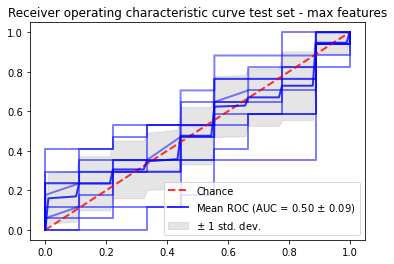

In [104]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="b", lw=2, alpha=0.5)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic curve {which_set} set - max features",
)
ax.legend(loc="lower right")
plt.show()